# Weather Data from Era5

In [1]:
%pip install cdsapi xarray netcdf4 scipy numpy pandas

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------------------------------ --------- 1.0/1.4 MB 49.2 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 4.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/7.1 MB ? eta -:--:--
   ----------- ---------------------------- 2.1/7.1 MB 29.6 MB/s eta 0:00:01
   ----------------------- ---------------- 4.2/7.1 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------- 7.1/7.1 MB 11.0 MB/s eta 0:00:00

   ------ --------------------------------- 1/6 [netcdf4]
   ------------- -------------------------- 2/6 [multiurl]
   -------------------- ------------------- 3/6 [xarray]
   -------------------- ------------------- 3/6 [xarray]
   -------------------- ------------------- 3/6 [xarray]
   -------------------- ------------------- 3/6 [xarray]
   -------------------- ------------------- 3/6 [xarray]
   -------------------- ------------------- 3/6 [xarray]
   ---------------


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
%pip install cfgrib

   ---------------------------------------- 0.0/7.2 MB ? eta -:--:--
   -------------------------- ------------- 4.7/7.2 MB 25.9 MB/s eta 0:00:01
   ---------------------------------------- 7.2/7.2 MB 22.3 MB/s eta 0:00:00

   -------- ------------------------------- 1/5 [pycparser]
   ---------------- ----------------------- 2/5 [cffi]
   ---------------- ----------------------- 2/5 [cffi]
   ------------------------ --------------- 3/5 [eccodes]
   ------------------------ --------------- 3/5 [eccodes]
   -------------------------------- ------- 4/5 [cfgrib]
   -------------------------------- ------- 4/5 [cfgrib]
   -------------------------------- ------- 4/5 [cfgrib]
   ---------------------------------------- 5/5 [cfgrib]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import cdsapi
import xarray as xr
import pandas as pd
import numpy as np
import os
import zipfile
import shutil

YEAR = "2024"

# DOWNLOAD ERA5 DATA BY MONTH (ZIP WITH NETCDF FILES)

def download_era5_monthly(
    year=YEAR,
    month="01",
    out_folder="weather_data",
    spatial_resolution=2.5,
    temporal_resolution=6,
    north=40, south=-20,
    east=150, west=60
):
    """
    Downloads ERA5 hourly weather for a given month as ZIP file. Applies spatial and temporal sampling.
    """
    
    os.makedirs(out_folder, exist_ok=True)
    zip_file = os.path.join(out_folder, f"era5_{year}_{month}.zip")

    if os.path.exists(zip_file):
        print(f"✔ {zip_file} already exists — skipping download.")
        return zip_file

    c = cdsapi.Client()

    # Generate time list based on temporal resolution
    times = [f"{h:02d}:00" for h in range(0, 24, temporal_resolution)]

    print(f"⬇ Downloading ERA5 data for {year}-{month}...")
    print(f"   Spatial: {spatial_resolution}° grid")
    print(f"   Temporal: Every {temporal_resolution}h ({len(times)} times/day)")

    c.retrieve(
        "reanalysis-era5-single-levels",
        {
            "product_type": "reanalysis",
            "format": "netcdf",
            "variable": [
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "2m_temperature",
                "surface_pressure",
                "mean_sea_level_pressure",
                "total_precipitation",
            ],
            "year": year,
            "month": month,
            "day": [f"{d:02d}" for d in range(1, 32)],
            "time": times,
            "area": [north, west, south, east],
            "grid": [spatial_resolution, spatial_resolution],
        },
        zip_file,
    )

    file_size_mb = os.path.getsize(zip_file) / (1024 * 1024)
    print(f"✔ Downloaded → {zip_file} ({file_size_mb:.1f} MB)")
    return zip_file

# EXTRACT ZIP FILE

def extract_zip(zip_path, extract_folder):
    """Extract zip file to a folder."""
    if not os.path.exists(zip_path):
        print(f"⚠ {zip_path} not found")
        return None
    
    os.makedirs(extract_folder, exist_ok=True)
    
    print(f"📦 Extracting {zip_path}...")
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    
    extracted_files = os.listdir(extract_folder)
    print(f"  Extracted: {extracted_files}")
    
    return extract_folder

# CONVERT NETCDF TO CSV

def convert_monthly_nc_to_csv(extract_folder, month, year=YEAR, output_csv=None):
    """Convert split monthly NetCDF files to CSV."""
    
    if output_csv is None:
        output_csv = f"era5_{year}_{month}.csv"
    
    if os.path.exists(output_csv):
        print(f"✔ {output_csv} already exists — skipping conversion.")
        return output_csv
    
    nc_files = [f for f in os.listdir(extract_folder) if f.endswith('.nc')]
    
    if len(nc_files) == 0:
        print(f"⚠ No NetCDF files in {extract_folder}")
        return None
    
    print(f"📡 Loading {year}-{month}...")
    print(f"  Files: {nc_files}")
    
    datasets = []
    for nc_file in nc_files:
        nc_path = os.path.join(extract_folder, nc_file)
        try:
            ds = xr.open_dataset(nc_path, engine='netcdf4')
            print(f"  ✓ {nc_file}: {list(ds.data_vars)}")
            datasets.append(ds)
        except Exception as e:
            print(f"  ✗ Error loading {nc_file}: {e}")
    
    if len(datasets) == 0:
        return None
    
    print("🔗 Merging datasets...")
    ds_merged = xr.merge(datasets)
    
    print("🛠 Converting to DataFrame...")
    df = ds_merged.to_dataframe().reset_index()
    
    # Check what columns we got
    print(f"  Initial columns: {list(df.columns)}")
    
    # Handle different time column names
    time_col = None
    for col in ['time', 'valid_time', 't']:
        if col in df.columns:
            time_col = col
            break
    
    if time_col and time_col != 'time':
        df = df.rename(columns={time_col: 'time'})
        print(f"  Renamed '{time_col}' to 'time'")
    
    # Compute wind speed
    if 'u10' in df.columns and 'v10' in df.columns:
        df["wind_speed"] = np.sqrt(df["u10"]**2 + df["v10"]**2)
    
    # Select and order columns - INCLUDE TIME
    cols_to_keep = []
    for col in ["time", "latitude", "longitude", "u10", "v10", "wind_speed", "t2m", "sp", "msl", "tp"]:
        if col in df.columns:
            cols_to_keep.append(col)
    
    df_output = df[cols_to_keep] if cols_to_keep else df
    
    print(f"💾 Saving to CSV...")
    df_output.to_csv(output_csv, index=False)
    
    for ds in datasets:
        ds.close()
    
    print(f"✔ {output_csv} ({len(df_output):,} rows)")
    print(f"  Columns: {list(df_output.columns)}")
    return output_csv

# MERGE MONTHLY CSV FILES

def merge_monthly_csvs(year, months, output_csv):
    """
    Merge multiple monthly CSV files into one.
    """
    print("🔗 Merging monthly CSV files...")
    
    csv_files = [f"era5_{year}_{m:02d}.csv" for m in months]
    
    # Check if all files exist
    missing = [f for f in csv_files if not os.path.exists(f)]
    if missing:
        print(f"⚠ Missing files: {missing}")
        return None
    
    print(f"Found {len(csv_files)} CSV files to merge")
    
    # Read and concatenate all CSVs
    dfs = []
    for csv_file in csv_files:
        print(f"  Reading {csv_file}...")
        df = pd.read_csv(csv_file, parse_dates=['time'])
        dfs.append(df)
    
    print("Concatenating dataframes...")
    merged_df = pd.concat(dfs, ignore_index=True)
    
    # Sort by time
    print("Sorting by time...")
    merged_df = merged_df.sort_values('time').reset_index(drop=True)
    
    # Save merged CSV
    print(f"💾 Saving merged CSV...")
    merged_df.to_csv(output_csv, index=False)
    
    print(f"✔ Merged CSV saved → {output_csv}")
    print(f"  Total rows: {len(merged_df):,}")
    
    return output_csv

# MAIN

if __name__ == "__main__":

    OUTPUT_CSV = f"era5_weather_{YEAR}_sampled.csv"
    WEATHER_DATA_FOLDER = "weather_data"

    # SAMPLING CONFIGURATION
    SPATIAL_RES = 2.5   # 2.5° grid (~250km resolution)
    TEMPORAL_RES = 6    # Every 6 hours (00:00, 06:00, 12:00, 18:00)

    # Step A — Download ERA5 weather by month (with sampling)
    print("=" * 60)
    print(f"DOWNLOADING SAMPLED ERA5 DATA FOR {YEAR}")
    print("=" * 60)
    print(f"📊 Spatial: {SPATIAL_RES}° grid (~{int(SPATIAL_RES * 111)}km)")
    print(f"⏰ Temporal: Every {TEMPORAL_RES} hours")
    print("=" * 60)
    
    for m in range(1, 13):
        month = f"{m:02d}"
        
        try:
            download_era5_monthly(
                year=YEAR,
                month=month,
                out_folder=WEATHER_DATA_FOLDER,
                spatial_resolution=SPATIAL_RES,
                temporal_resolution=TEMPORAL_RES,
                north=40,
                south=-20,
                east=150,
                west=60
            )
        except Exception as e:
            print(f"❌ Error downloading {month}: {e}")
            continue

    # Step B — Extract and convert each monthly ZIP to CSV
    print("\n" + "=" * 60)
    print("EXTRACTING AND CONVERTING TO CSV")
    print("=" * 60)
    
    for m in range(1, 13):
        month = f"{m:02d}"
        zip_file = os.path.join(WEATHER_DATA_FOLDER, f"era5_{YEAR}_{month}.zip")
        extract_folder = f"era5_{YEAR}_{month}_extracted"
        csv_file = f"era5_{YEAR}_{month}.csv"
        
        if os.path.exists(zip_file):
            try:
                extract_zip(zip_file, extract_folder)
                convert_monthly_nc_to_csv(extract_folder, month, YEAR, csv_file)
                # Cleanup temporary extraction folder
                shutil.rmtree(extract_folder, ignore_errors=True)
            except Exception as e:
                print(f"❌ Error converting {month}: {e}")
                continue
        else:
            print(f"⚠ Skipping {month} - zip file not found")

    # Step C — Merge all monthly CSVs
    print("\n" + "=" * 60)
    print("MERGING ALL MONTHLY CSV FILES")
    print("=" * 60)
    
    merge_monthly_csvs(
        year=YEAR,
        months=range(1, 13),
        output_csv=OUTPUT_CSV
    )
    
    print("\n✅ All done!")

DOWNLOADING SAMPLED ERA5 DATA FOR 2024
📊 Spatial: 2.5° grid (~277km)
⏰ Temporal: Every 6 hours


2025-12-11 03:13:00,138 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


⬇ Downloading ERA5 data for 2024-01...
   Spatial: 2.5° grid
   Temporal: Every 6h (4 times/day)


2025-12-11 03:13:00,883 INFO Request ID is 36728d35-0312-43a8-bb3b-135b4cf2273c
2025-12-11 03:13:01,078 INFO status has been updated to accepted
2025-12-11 03:13:34,548 INFO status has been updated to running
2025-12-11 03:14:18,015 INFO status has been updated to successful


✔ Downloaded → weather_data\era5_2024_01.zip (1.4 MB)


2025-12-11 03:14:21,690 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


⬇ Downloading ERA5 data for 2024-02...
   Spatial: 2.5° grid
   Temporal: Every 6h (4 times/day)


2025-12-11 03:14:22,362 INFO Request ID is 5cbcb9e2-ed36-4d46-868e-9605b0938e10
2025-12-11 03:14:22,553 INFO status has been updated to accepted
2025-12-11 03:14:37,048 INFO status has been updated to running
2025-12-11 03:14:56,414 INFO status has been updated to successful


✔ Downloaded → weather_data\era5_2024_02.zip (1.3 MB)


2025-12-11 03:14:59,650 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


⬇ Downloading ERA5 data for 2024-03...
   Spatial: 2.5° grid
   Temporal: Every 6h (4 times/day)


2025-12-11 03:15:00,289 INFO Request ID is c797b24e-e308-4bfe-ac90-5891a5f13279
2025-12-11 03:15:00,492 INFO status has been updated to accepted
2025-12-11 03:15:14,639 INFO status has been updated to running
2025-12-11 03:15:51,285 INFO status has been updated to successful


✔ Downloaded → weather_data\era5_2024_03.zip (1.4 MB)


2025-12-11 03:15:54,455 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


⬇ Downloading ERA5 data for 2024-04...
   Spatial: 2.5° grid
   Temporal: Every 6h (4 times/day)


2025-12-11 03:15:55,050 INFO Request ID is ce183092-8443-4b8c-9cee-b4dc54b2d9c7
2025-12-11 03:15:55,233 INFO status has been updated to accepted
2025-12-11 03:16:09,337 INFO status has been updated to running
2025-12-11 03:17:11,815 INFO status has been updated to successful


✔ Downloaded → weather_data\era5_2024_04.zip (1.3 MB)


2025-12-11 03:17:15,143 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


⬇ Downloading ERA5 data for 2024-05...
   Spatial: 2.5° grid
   Temporal: Every 6h (4 times/day)


2025-12-11 03:17:15,733 INFO Request ID is 0f92bd36-15a1-4a86-a7f8-b6dcbce71881
2025-12-11 03:17:15,921 INFO status has been updated to accepted
2025-12-11 03:17:24,768 INFO status has been updated to running
2025-12-11 03:18:14,511 INFO status has been updated to successful


✔ Downloaded → weather_data\era5_2024_05.zip (1.4 MB)


2025-12-11 03:18:17,833 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


⬇ Downloading ERA5 data for 2024-06...
   Spatial: 2.5° grid
   Temporal: Every 6h (4 times/day)


2025-12-11 03:18:18,803 INFO Request ID is 994e0446-403d-4e9f-b23c-2f747826cb33
2025-12-11 03:18:19,011 INFO status has been updated to accepted
2025-12-11 03:18:27,963 INFO status has been updated to running
2025-12-11 03:18:52,601 INFO status has been updated to successful


✔ Downloaded → weather_data\era5_2024_06.zip (1.4 MB)


2025-12-11 03:18:55,927 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


⬇ Downloading ERA5 data for 2024-07...
   Spatial: 2.5° grid
   Temporal: Every 6h (4 times/day)


2025-12-11 03:18:56,595 INFO Request ID is 489958dc-f7cc-4cac-8217-d25fd5272741
2025-12-11 03:18:56,798 INFO status has been updated to accepted
2025-12-11 03:19:05,694 INFO status has been updated to running
2025-12-11 03:20:13,418 INFO status has been updated to successful


✔ Downloaded → weather_data\era5_2024_07.zip (1.4 MB)


2025-12-11 03:20:17,377 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


⬇ Downloading ERA5 data for 2024-08...
   Spatial: 2.5° grid
   Temporal: Every 6h (4 times/day)


2025-12-11 03:20:18,024 INFO Request ID is 18a49765-c538-4a46-8ceb-56aa4970c506
2025-12-11 03:20:18,227 INFO status has been updated to accepted
2025-12-11 03:20:34,450 INFO status has been updated to running
2025-12-11 03:21:36,924 INFO status has been updated to successful


✔ Downloaded → weather_data\era5_2024_08.zip (1.4 MB)


2025-12-11 03:21:40,151 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


⬇ Downloading ERA5 data for 2024-09...
   Spatial: 2.5° grid
   Temporal: Every 6h (4 times/day)


2025-12-11 03:21:40,905 INFO Request ID is cf7d8c15-7375-413c-ac49-6226f54ad403
2025-12-11 03:21:41,108 INFO status has been updated to accepted
2025-12-11 03:21:55,270 INFO status has been updated to running
2025-12-11 03:22:57,737 INFO status has been updated to successful


✔ Downloaded → weather_data\era5_2024_09.zip (1.4 MB)


2025-12-11 03:23:01,039 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


⬇ Downloading ERA5 data for 2024-10...
   Spatial: 2.5° grid
   Temporal: Every 6h (4 times/day)


2025-12-11 03:23:01,701 INFO Request ID is 7fc61298-82de-4f6e-8330-cc763db6706b
2025-12-11 03:23:01,894 INFO status has been updated to accepted
2025-12-11 03:23:16,055 INFO status has been updated to running
2025-12-11 03:23:52,691 INFO status has been updated to successful


✔ Downloaded → weather_data\era5_2024_10.zip (1.4 MB)


2025-12-11 03:23:55,832 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


⬇ Downloading ERA5 data for 2024-11...
   Spatial: 2.5° grid
   Temporal: Every 6h (4 times/day)


2025-12-11 03:23:56,457 INFO Request ID is ffefed66-27c7-40a5-bdaf-ebc2734805a6
2025-12-11 03:23:56,635 INFO status has been updated to accepted
2025-12-11 03:24:05,536 INFO status has been updated to running
2025-12-11 03:24:47,683 INFO status has been updated to successful


✔ Downloaded → weather_data\era5_2024_11.zip (1.4 MB)


2025-12-11 03:24:51,045 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


⬇ Downloading ERA5 data for 2024-12...
   Spatial: 2.5° grid
   Temporal: Every 6h (4 times/day)


2025-12-11 03:24:51,790 INFO Request ID is 344073bc-0ef8-471d-b752-9a05ffa28b8e
2025-12-11 03:24:52,005 INFO status has been updated to accepted
2025-12-11 03:25:06,187 INFO status has been updated to running
2025-12-11 03:26:08,799 INFO status has been updated to successful
C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)
C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different resu

✔ Downloaded → weather_data\era5_2024_12.zip (1.4 MB)

EXTRACTING AND CONVERTING TO CSV
📦 Extracting weather_data\era5_2024_01.zip...
  Extracted: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
📡 Loading 2024-01...
  Files: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
  ✓ data_stream-oper_stepType-accum.nc: ['tp']
  ✓ data_stream-oper_stepType-instant.nc: ['u10', 'v10', 't2m', 'sp', 'msl']
🔗 Merging datasets...
🛠 Converting to DataFrame...
  Initial columns: ['valid_time', 'latitude', 'longitude', 'tp', 'number', 'expver', 'u10', 'v10', 't2m', 'sp', 'msl']
  Renamed 'valid_time' to 'time'
💾 Saving to CSV...
✔ era5_2024_01.csv (114,700 rows)
  Columns: ['time', 'latitude', 'longitude', 'u10', 'v10', 'wind_speed', 't2m', 'sp', 'msl', 'tp']
📦 Extracting weather_data\era5_2024_02.zip...
  Extracted: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
📡 Loading 2024-02...
  Files: ['data_stream-oper

C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)
C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)


✔ era5_2024_02.csv (107,300 rows)
  Columns: ['time', 'latitude', 'longitude', 'u10', 'v10', 'wind_speed', 't2m', 'sp', 'msl', 'tp']
📦 Extracting weather_data\era5_2024_03.zip...
  Extracted: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
📡 Loading 2024-03...
  Files: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
  ✓ data_stream-oper_stepType-accum.nc: ['tp']
  ✓ data_stream-oper_stepType-instant.nc: ['u10', 'v10', 't2m', 'sp', 'msl']
🔗 Merging datasets...
🛠 Converting to DataFrame...
  Initial columns: ['valid_time', 'latitude', 'longitude', 'tp', 'number', 'expver', 'u10', 'v10', 't2m', 'sp', 'msl']
  Renamed 'valid_time' to 'time'
💾 Saving to CSV...


C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)
C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)


✔ era5_2024_03.csv (114,700 rows)
  Columns: ['time', 'latitude', 'longitude', 'u10', 'v10', 'wind_speed', 't2m', 'sp', 'msl', 'tp']
📦 Extracting weather_data\era5_2024_04.zip...
  Extracted: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
📡 Loading 2024-04...
  Files: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
  ✓ data_stream-oper_stepType-accum.nc: ['tp']
  ✓ data_stream-oper_stepType-instant.nc: ['u10', 'v10', 't2m', 'sp', 'msl']
🔗 Merging datasets...
🛠 Converting to DataFrame...
  Initial columns: ['valid_time', 'latitude', 'longitude', 'tp', 'number', 'expver', 'u10', 'v10', 't2m', 'sp', 'msl']
  Renamed 'valid_time' to 'time'
💾 Saving to CSV...


C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)
C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)


✔ era5_2024_04.csv (111,000 rows)
  Columns: ['time', 'latitude', 'longitude', 'u10', 'v10', 'wind_speed', 't2m', 'sp', 'msl', 'tp']
📦 Extracting weather_data\era5_2024_05.zip...
  Extracted: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
📡 Loading 2024-05...
  Files: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
  ✓ data_stream-oper_stepType-accum.nc: ['tp']
  ✓ data_stream-oper_stepType-instant.nc: ['u10', 'v10', 't2m', 'sp', 'msl']
🔗 Merging datasets...
🛠 Converting to DataFrame...
  Initial columns: ['valid_time', 'latitude', 'longitude', 'tp', 'number', 'expver', 'u10', 'v10', 't2m', 'sp', 'msl']
  Renamed 'valid_time' to 'time'
💾 Saving to CSV...


C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)
C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)


✔ era5_2024_05.csv (114,700 rows)
  Columns: ['time', 'latitude', 'longitude', 'u10', 'v10', 'wind_speed', 't2m', 'sp', 'msl', 'tp']
📦 Extracting weather_data\era5_2024_06.zip...
  Extracted: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
📡 Loading 2024-06...
  Files: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
  ✓ data_stream-oper_stepType-accum.nc: ['tp']
  ✓ data_stream-oper_stepType-instant.nc: ['u10', 'v10', 't2m', 'sp', 'msl']
🔗 Merging datasets...
🛠 Converting to DataFrame...
  Initial columns: ['valid_time', 'latitude', 'longitude', 'tp', 'number', 'expver', 'u10', 'v10', 't2m', 'sp', 'msl']
  Renamed 'valid_time' to 'time'
💾 Saving to CSV...


C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)
C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)


✔ era5_2024_06.csv (111,000 rows)
  Columns: ['time', 'latitude', 'longitude', 'u10', 'v10', 'wind_speed', 't2m', 'sp', 'msl', 'tp']
📦 Extracting weather_data\era5_2024_07.zip...
  Extracted: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
📡 Loading 2024-07...
  Files: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
  ✓ data_stream-oper_stepType-accum.nc: ['tp']
  ✓ data_stream-oper_stepType-instant.nc: ['u10', 'v10', 't2m', 'sp', 'msl']
🔗 Merging datasets...
🛠 Converting to DataFrame...
  Initial columns: ['valid_time', 'latitude', 'longitude', 'tp', 'number', 'expver', 'u10', 'v10', 't2m', 'sp', 'msl']
  Renamed 'valid_time' to 'time'
💾 Saving to CSV...


C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)
C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)


✔ era5_2024_07.csv (114,700 rows)
  Columns: ['time', 'latitude', 'longitude', 'u10', 'v10', 'wind_speed', 't2m', 'sp', 'msl', 'tp']
📦 Extracting weather_data\era5_2024_08.zip...
  Extracted: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
📡 Loading 2024-08...
  Files: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
  ✓ data_stream-oper_stepType-accum.nc: ['tp']
  ✓ data_stream-oper_stepType-instant.nc: ['u10', 'v10', 't2m', 'sp', 'msl']
🔗 Merging datasets...
🛠 Converting to DataFrame...
  Initial columns: ['valid_time', 'latitude', 'longitude', 'tp', 'number', 'expver', 'u10', 'v10', 't2m', 'sp', 'msl']
  Renamed 'valid_time' to 'time'
💾 Saving to CSV...


C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)
C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)


✔ era5_2024_08.csv (114,700 rows)
  Columns: ['time', 'latitude', 'longitude', 'u10', 'v10', 'wind_speed', 't2m', 'sp', 'msl', 'tp']
📦 Extracting weather_data\era5_2024_09.zip...
  Extracted: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
📡 Loading 2024-09...
  Files: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
  ✓ data_stream-oper_stepType-accum.nc: ['tp']
  ✓ data_stream-oper_stepType-instant.nc: ['u10', 'v10', 't2m', 'sp', 'msl']
🔗 Merging datasets...
🛠 Converting to DataFrame...
  Initial columns: ['valid_time', 'latitude', 'longitude', 'tp', 'number', 'expver', 'u10', 'v10', 't2m', 'sp', 'msl']
  Renamed 'valid_time' to 'time'
💾 Saving to CSV...


C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)
C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)


✔ era5_2024_09.csv (111,000 rows)
  Columns: ['time', 'latitude', 'longitude', 'u10', 'v10', 'wind_speed', 't2m', 'sp', 'msl', 'tp']
📦 Extracting weather_data\era5_2024_10.zip...
  Extracted: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
📡 Loading 2024-10...
  Files: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
  ✓ data_stream-oper_stepType-accum.nc: ['tp']
  ✓ data_stream-oper_stepType-instant.nc: ['u10', 'v10', 't2m', 'sp', 'msl']
🔗 Merging datasets...
🛠 Converting to DataFrame...
  Initial columns: ['valid_time', 'latitude', 'longitude', 'tp', 'number', 'expver', 'u10', 'v10', 't2m', 'sp', 'msl']
  Renamed 'valid_time' to 'time'
💾 Saving to CSV...


C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)
C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)


✔ era5_2024_10.csv (114,700 rows)
  Columns: ['time', 'latitude', 'longitude', 'u10', 'v10', 'wind_speed', 't2m', 'sp', 'msl', 'tp']
📦 Extracting weather_data\era5_2024_11.zip...
  Extracted: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
📡 Loading 2024-11...
  Files: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
  ✓ data_stream-oper_stepType-accum.nc: ['tp']
  ✓ data_stream-oper_stepType-instant.nc: ['u10', 'v10', 't2m', 'sp', 'msl']
🔗 Merging datasets...
🛠 Converting to DataFrame...
  Initial columns: ['valid_time', 'latitude', 'longitude', 'tp', 'number', 'expver', 'u10', 'v10', 't2m', 'sp', 'msl']
  Renamed 'valid_time' to 'time'
💾 Saving to CSV...


C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)
C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)


✔ era5_2024_11.csv (111,000 rows)
  Columns: ['time', 'latitude', 'longitude', 'u10', 'v10', 'wind_speed', 't2m', 'sp', 'msl', 'tp']
📦 Extracting weather_data\era5_2024_12.zip...
  Extracted: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
📡 Loading 2024-12...
  Files: ['data_stream-oper_stepType-accum.nc', 'data_stream-oper_stepType-instant.nc']
  ✓ data_stream-oper_stepType-accum.nc: ['tp']
  ✓ data_stream-oper_stepType-instant.nc: ['u10', 'v10', 't2m', 'sp', 'msl']
🔗 Merging datasets...
🛠 Converting to DataFrame...
  Initial columns: ['valid_time', 'latitude', 'longitude', 'tp', 'number', 'expver', 'u10', 'v10', 't2m', 'sp', 'msl']
  Renamed 'valid_time' to 'time'
💾 Saving to CSV...


C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)
C:\Users\EE HANN\AppData\Local\Temp\ipykernel_8916\1626240574.py:124: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_merged = xr.merge(datasets)


✔ era5_2024_12.csv (114,700 rows)
  Columns: ['time', 'latitude', 'longitude', 'u10', 'v10', 'wind_speed', 't2m', 'sp', 'msl', 'tp']

MERGING ALL MONTHLY CSV FILES
🔗 Merging monthly CSV files...
Found 12 CSV files to merge
  Reading era5_2024_01.csv...
  Reading era5_2024_02.csv...
  Reading era5_2024_03.csv...
  Reading era5_2024_04.csv...
  Reading era5_2024_05.csv...
  Reading era5_2024_06.csv...
  Reading era5_2024_07.csv...
  Reading era5_2024_08.csv...
  Reading era5_2024_09.csv...
  Reading era5_2024_10.csv...
  Reading era5_2024_11.csv...
  Reading era5_2024_12.csv...
Concatenating dataframes...
Sorting by time...
💾 Saving merged CSV...
✔ Merged CSV saved → era5_weather_2024_sampled.csv
  Total rows: 1,354,200

✅ All done!


ERA5 WEATHER DATA EXPLORATION - 2024
📁 Output folder: graphical analysis/weather_data

📊 Dataset Overview:
   Total records: 1,354,200
   Date range: 2024-01-01 00:00:00 to 2024-12-31 18:00:00
   Time span: 365 days
   Temporal resolution: 0 days 00:00:00

1. BASIC STATISTICS

📋 Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1354200 entries, 0 to 1354199
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   time        1354200 non-null  datetime64[ns]
 1   latitude    1354200 non-null  float64       
 2   longitude   1354200 non-null  float64       
 3   u10         1354200 non-null  float64       
 4   v10         1354200 non-null  float64       
 5   wind_speed  1354200 non-null  float64       
 6   t2m         1354200 non-null  float64       
 7   sp          1354200 non-null  float64       
 8   msl         1354200 non-null  float64       
 9   tp          1354200 non-null  float6

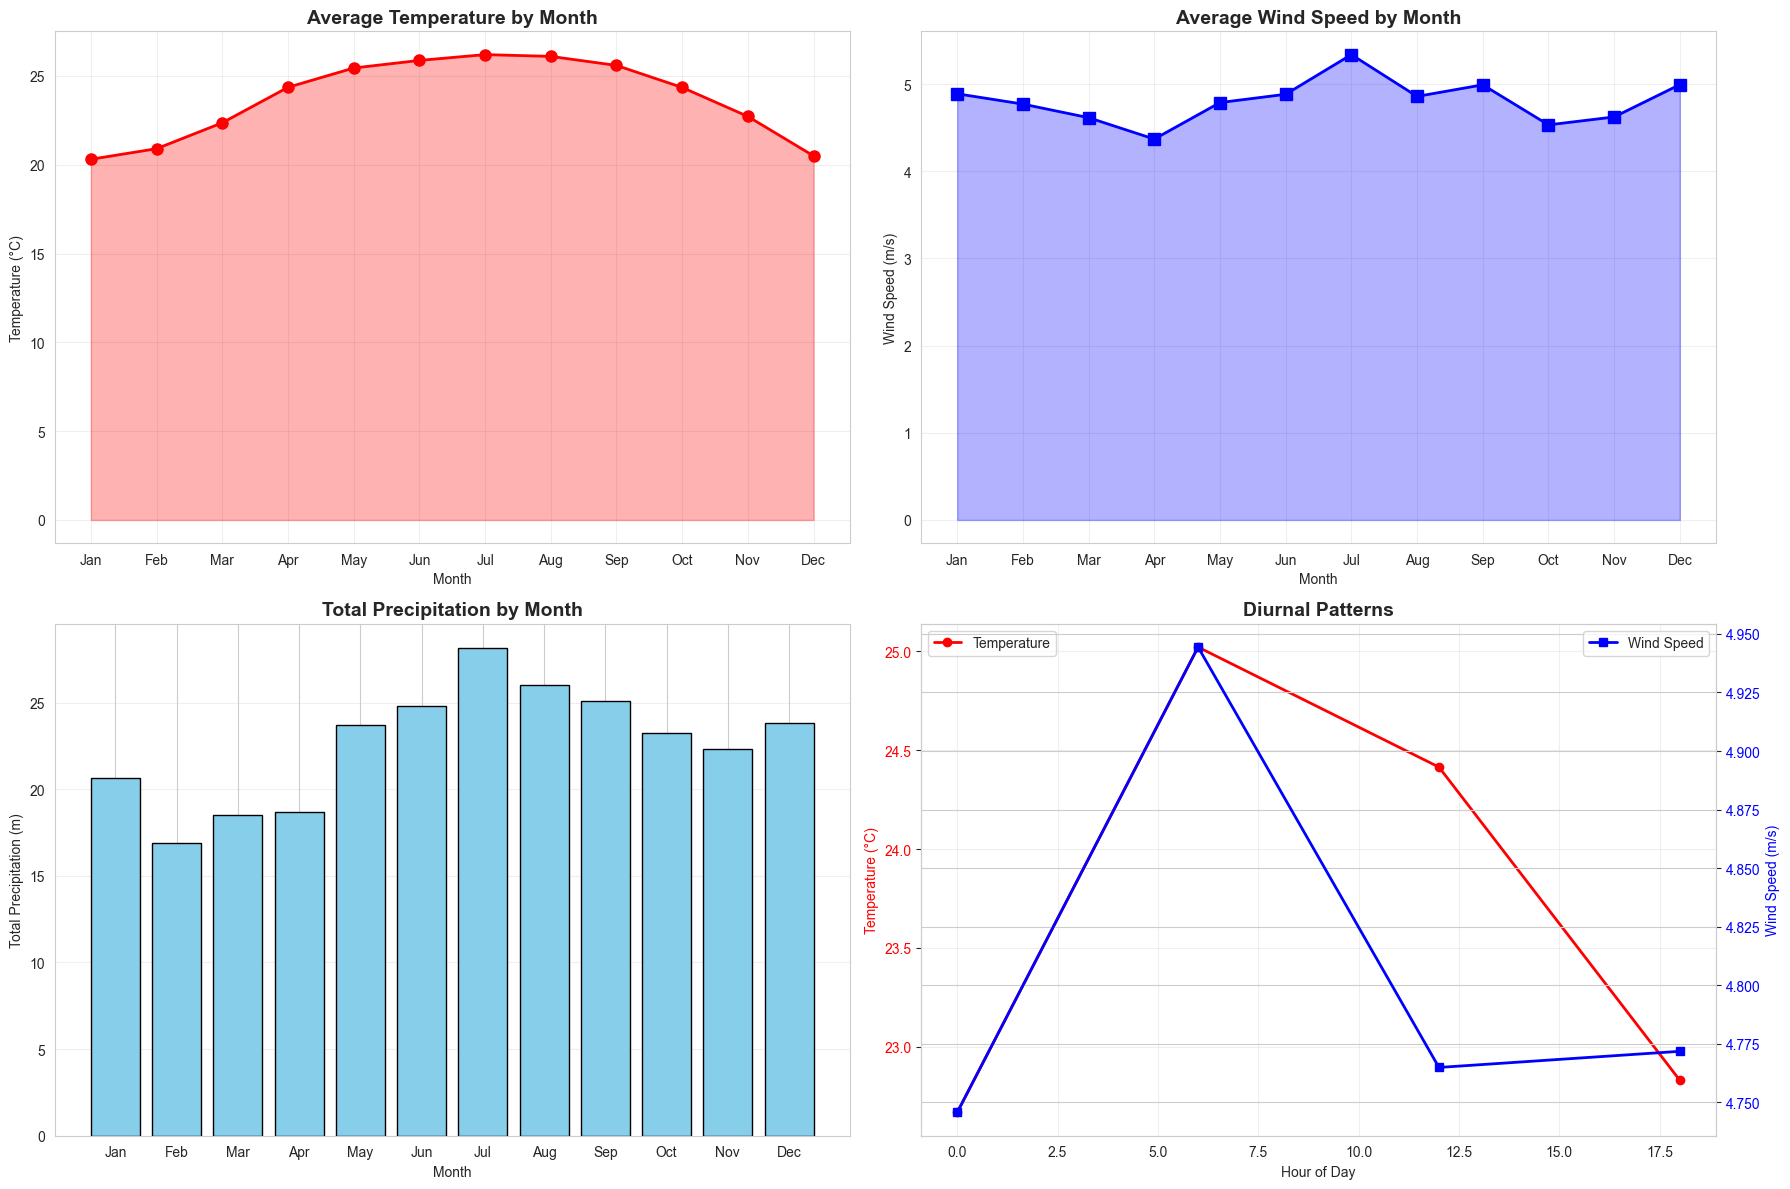


📈 Temporal Statistics:
   Warmest month: 7 (26.2°C)
   Coldest month: 1 (20.3°C)
   Windiest month: 7 (5.3 m/s)
   Wettest month: 7 (28.1378 m)

3. METEOROLOGICAL VARIABLE DISTRIBUTIONS


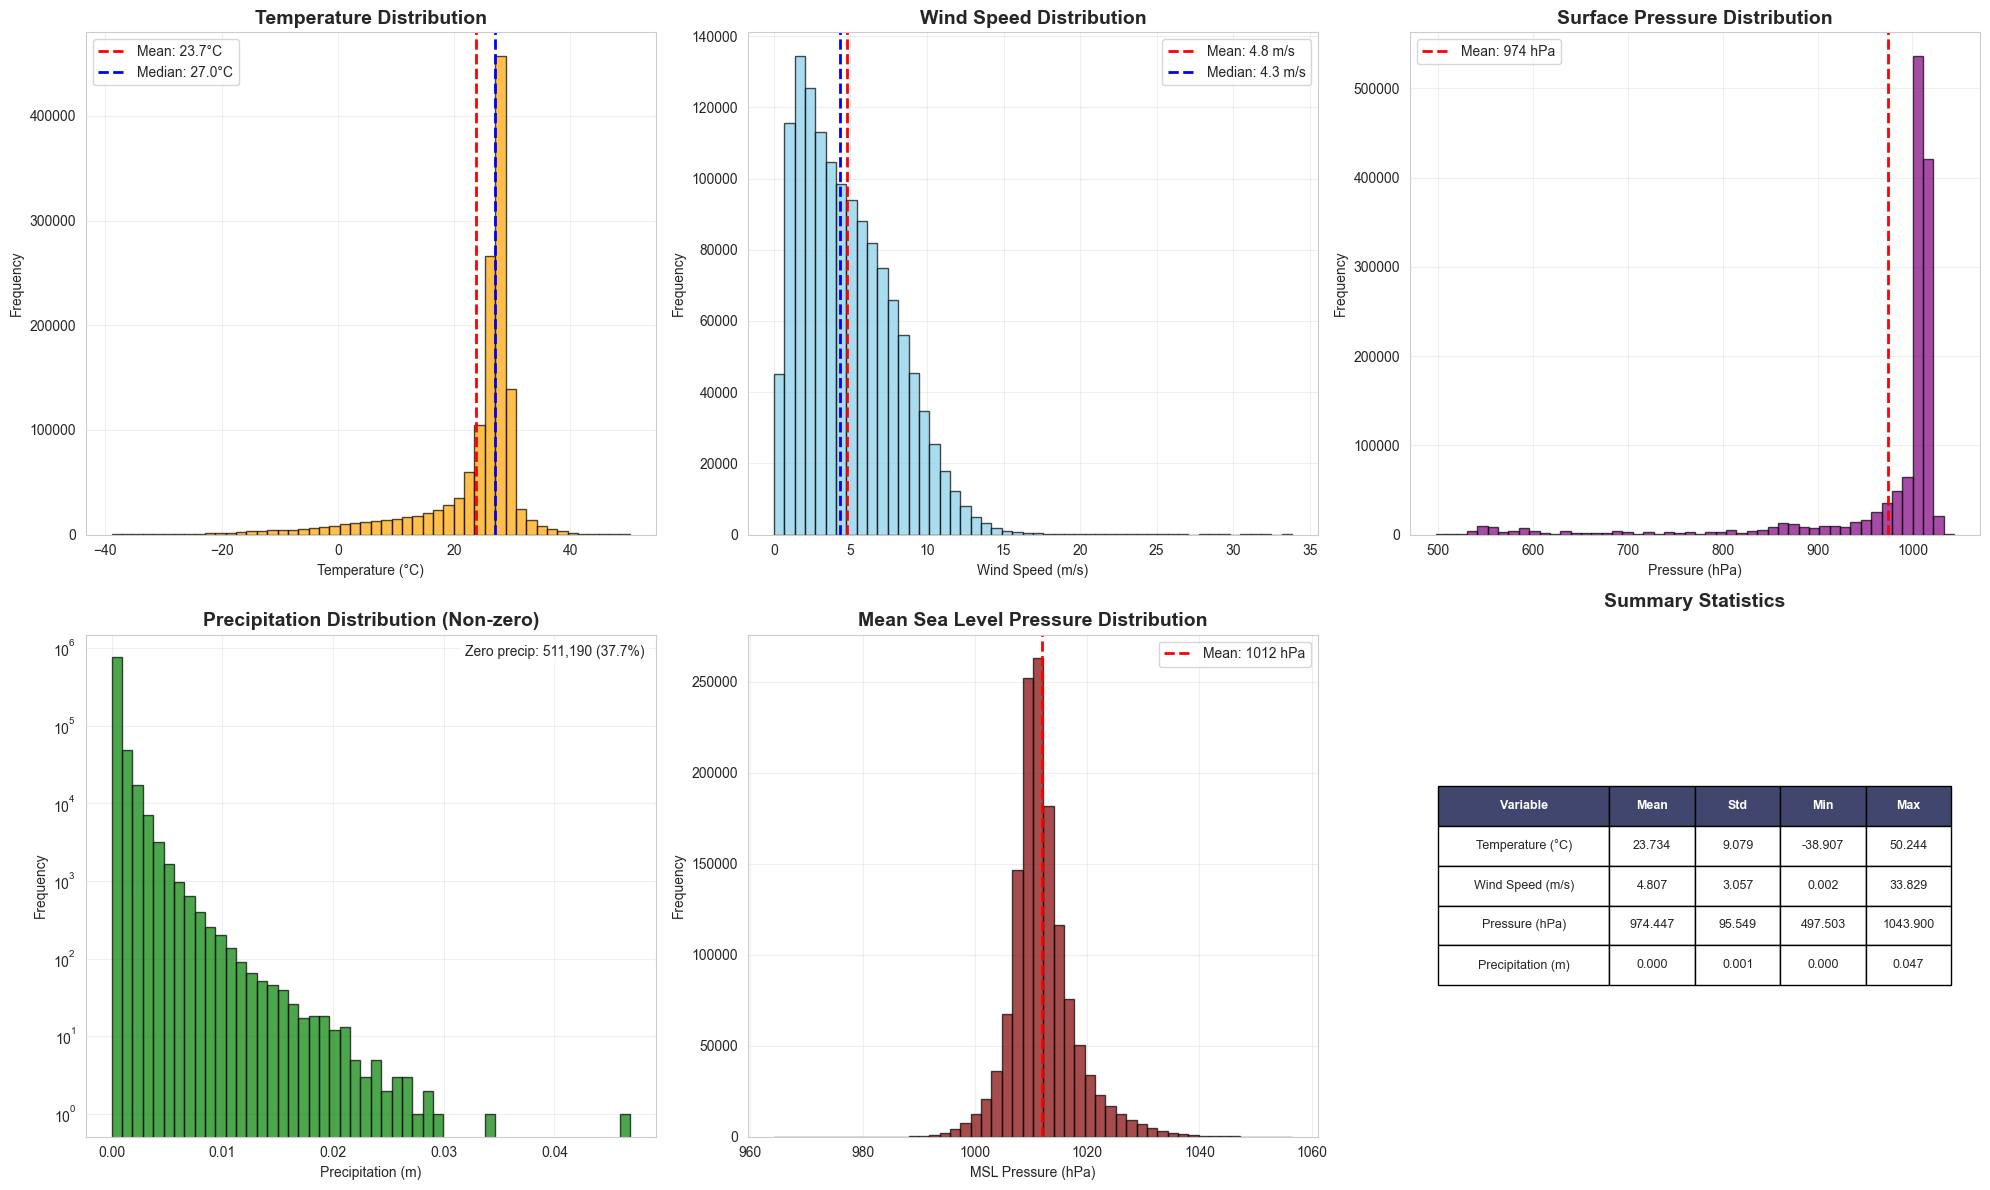


📊 Variable Statistics:
         Variable       Mean       Std        Min         Max
 Temperature (°C)  23.733672  9.078705 -38.906990   50.243550
 Wind Speed (m/s)   4.806729  3.057391   0.001649   33.829280
   Pressure (hPa) 974.446908 95.549273 497.503360 1043.900300
Precipitation (m)   0.000201  0.000659   0.000000    0.046818

4. SPATIAL DISTRIBUTION


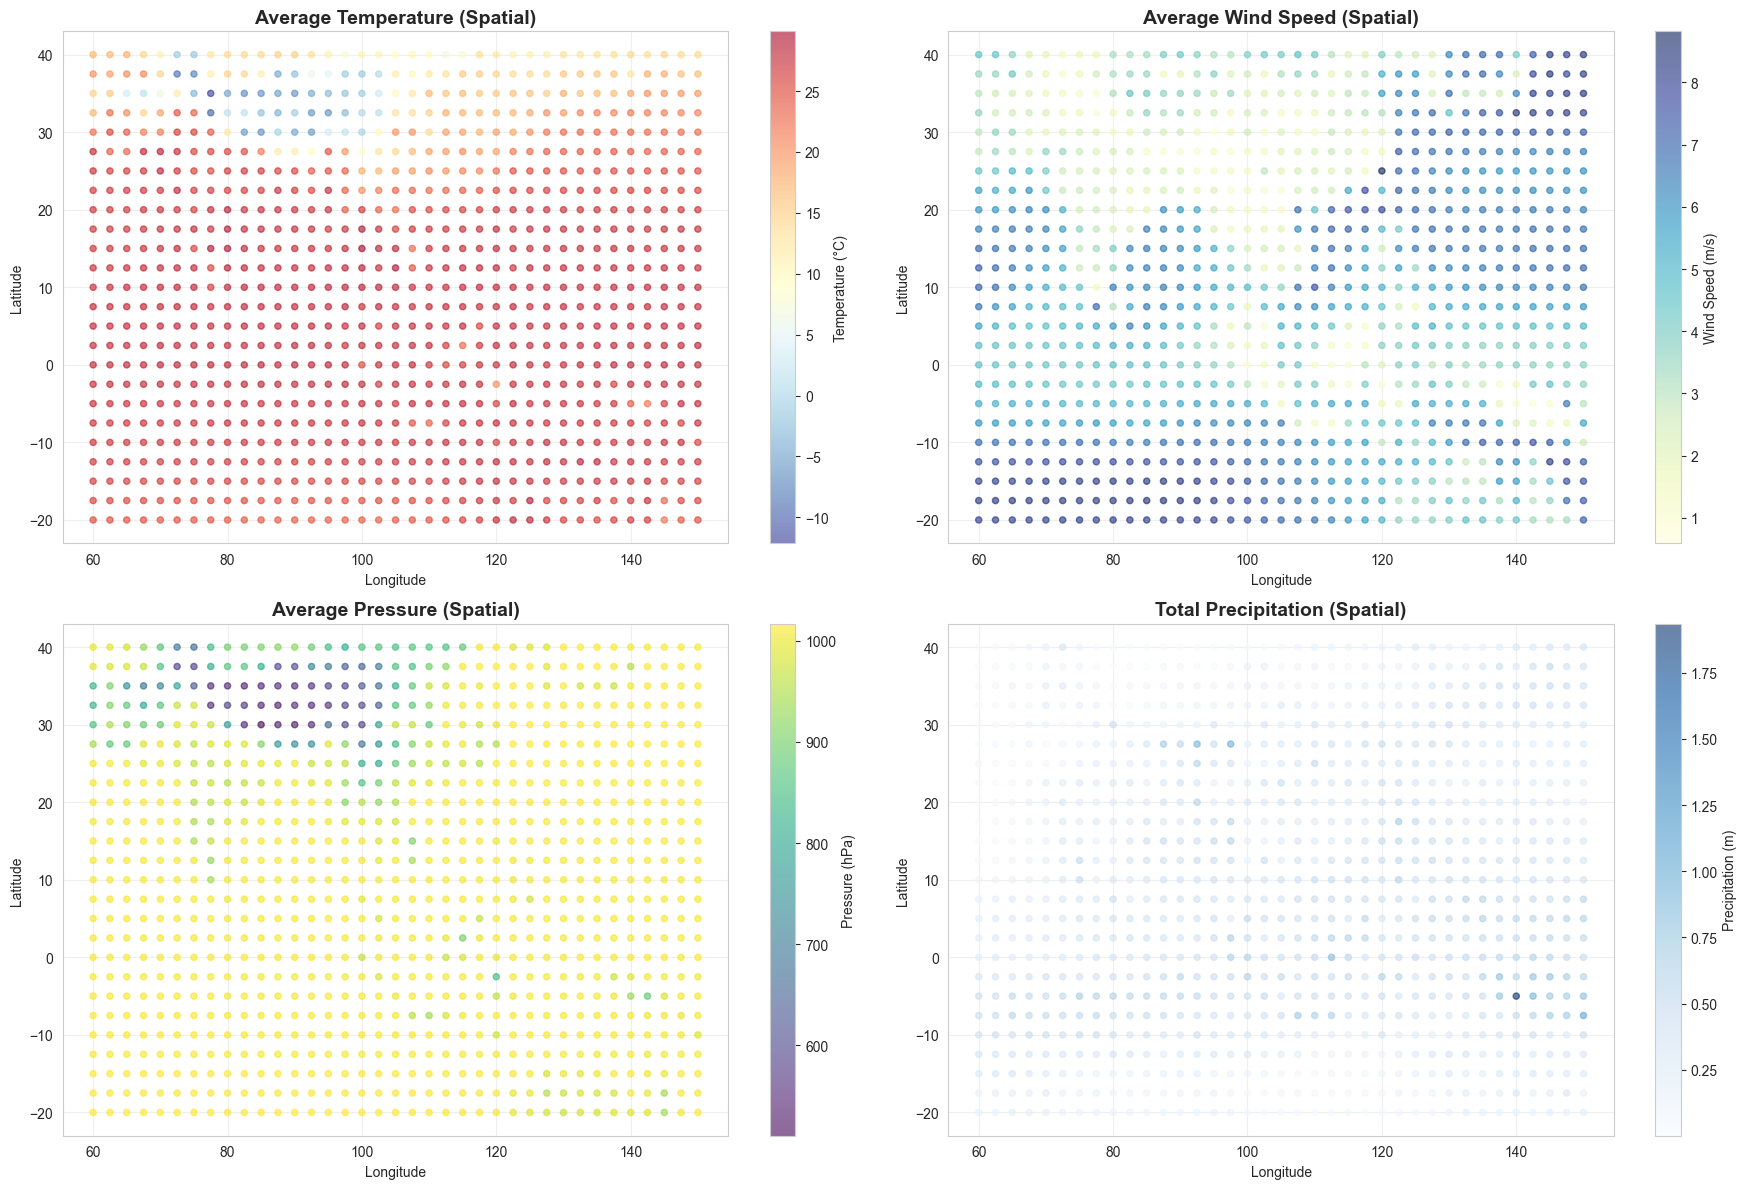


🌍 Spatial Coverage:
   Latitude range: [-20.00, 40.00]
   Longitude range: [60.00, 150.00]
   Unique grid points: 925

5. EXTREME WEATHER ANALYSIS


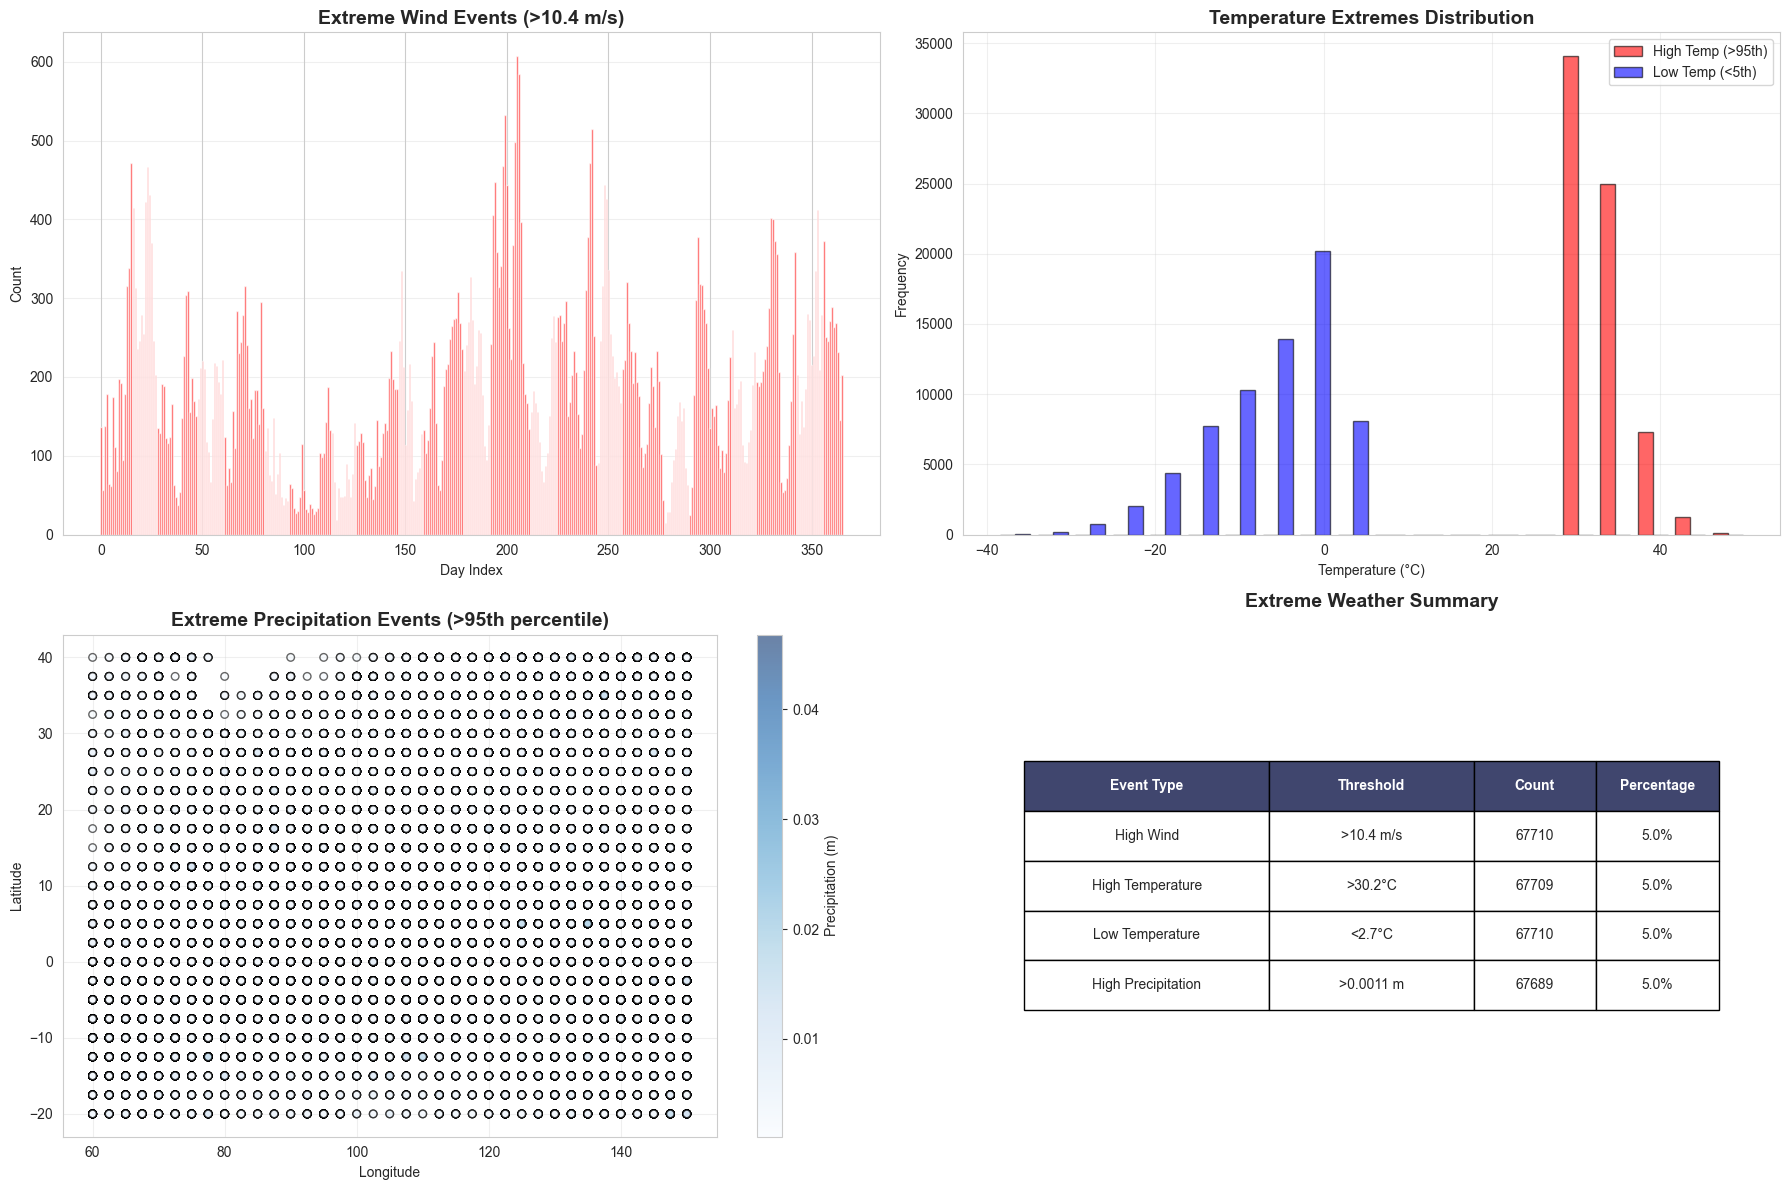


⚠️  Extreme Weather Events:
        Event Type Threshold  Count Percentage
         High Wind >10.4 m/s  67710       5.0%
  High Temperature   >30.2°C  67709       5.0%
   Low Temperature    <2.7°C  67710       5.0%
High Precipitation >0.0011 m  67689       5.0%

6. FEATURE CORRELATIONS


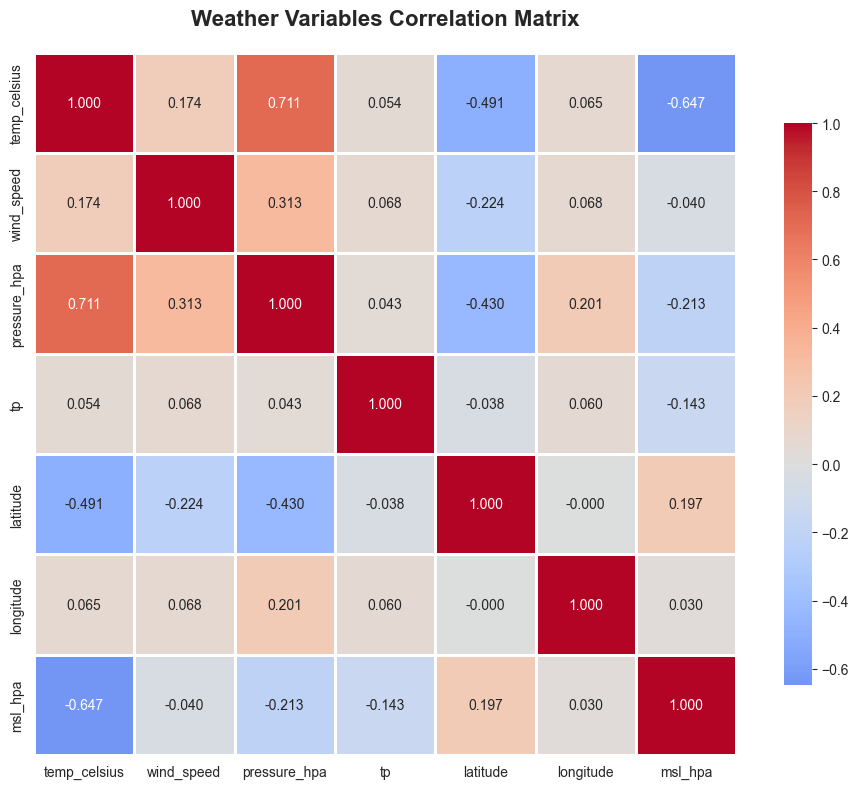


📊 Strong Correlations (|r| > 0.5):
   temp_celsius ↔ pressure_hpa: 0.711
   temp_celsius ↔ msl_hpa: -0.647

✅ WEATHER DATA EXPLORATION COMPLETE!

📁 All visualizations saved to: graphical analysis/weather_data/
   - temporal_analysis.png
   - variable_distributions.png
   - spatial_distribution.png
   - extreme_weather.png
   - correlation_matrix.png


In [1]:
# ============================================================================
# DATA UNDERSTANDING: ERA5 WEATHER DATA EXPLORATION
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

# ============================================================================
# CREATE OUTPUT FOLDER
# ============================================================================

SAMPLE_YEAR = 2024
OUTPUT_FOLDER = 'graphical analysis/weather_data'
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

print("="*80)
print(f"ERA5 WEATHER DATA EXPLORATION - {SAMPLE_YEAR}")
print("="*80)
print(f"📁 Output folder: {OUTPUT_FOLDER}")

# ============================================================================
# LOAD DATA
# ============================================================================

weather_file = f"era5_weather_{SAMPLE_YEAR}_sampled.csv"
df = pd.read_csv(weather_file, parse_dates=['time'])

print(f"\n📊 Dataset Overview:")
print(f"   Total records: {len(df):,}")
print(f"   Date range: {df['time'].min()} to {df['time'].max()}")
print(f"   Time span: {(df['time'].max() - df['time'].min()).days} days")
print(f"   Temporal resolution: {df['time'].diff().mode()[0]}")

# ============================================================================
# BASIC STATISTICS
# ============================================================================

print("\n" + "="*80)
print("1. BASIC STATISTICS")
print("="*80)

print("\n📋 Data Structure:")
print(df.info())

print("\n📊 Numerical Summary:")
print(df.describe())

print("\n❓ Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing[missing > 0],
    'Percentage': missing_pct[missing > 0]
})
if len(missing_df) > 0:
    print(missing_df)
else:
    print("   No missing values!")

# Create derived features if not present
if 'wind_speed' not in df.columns and 'u10' in df.columns and 'v10' in df.columns:
    df["wind_speed"] = np.sqrt(df["u10"]**2 + df["v10"]**2)

if 'temp_celsius' not in df.columns and 't2m' in df.columns:
    df['temp_celsius'] = df['t2m'] - 273.15

if 'pressure_hpa' not in df.columns and 'sp' in df.columns:
    df['pressure_hpa'] = df['sp'] / 100

print("\n🔧 Derived Features Created:")
print(f"   Wind Speed: {'✓' if 'wind_speed' in df.columns else '✗'}")
print(f"   Temperature (°C): {'✓' if 'temp_celsius' in df.columns else '✗'}")
print(f"   Pressure (hPa): {'✓' if 'pressure_hpa' in df.columns else '✗'}")

# ============================================================================
# TEMPORAL ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("2. TEMPORAL PATTERNS")
print("="*80)

# Create temporal features
df['Year'] = df['time'].dt.year
df['Month'] = df['time'].dt.month
df['MonthName'] = df['time'].dt.strftime('%b')
df['DayOfYear'] = df['time'].dt.dayofyear
df['Hour'] = df['time'].dt.hour
df['Quarter'] = df['time'].dt.quarter

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Temperature over time (monthly average)
monthly_temp = df.groupby('Month')['temp_celsius'].mean()
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 0].plot(range(1, 13), monthly_temp.values, marker='o', linewidth=2, markersize=8, color='red')
axes[0, 0].fill_between(range(1, 13), monthly_temp.values, alpha=0.3, color='red')
axes[0, 0].set_title('Average Temperature by Month', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(month_order[:12])
axes[0, 0].grid(True, alpha=0.3)

# 2. Wind speed over time (monthly average)
monthly_wind = df.groupby('Month')['wind_speed'].mean()
axes[0, 1].plot(range(1, 13), monthly_wind.values, marker='s', linewidth=2, markersize=8, color='blue')
axes[0, 1].fill_between(range(1, 13), monthly_wind.values, alpha=0.3, color='blue')
axes[0, 1].set_title('Average Wind Speed by Month', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Wind Speed (m/s)')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_order[:12])
axes[0, 1].grid(True, alpha=0.3)

# 3. Precipitation over time (monthly total)
monthly_precip = df.groupby('Month')['tp'].sum()
axes[1, 0].bar(range(1, 13), monthly_precip.values, color='skyblue', edgecolor='black')
axes[1, 0].set_title('Total Precipitation by Month', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Total Precipitation (m)')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(month_order[:12])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Diurnal patterns (by hour)
if df['Hour'].nunique() > 1:
    hourly_temp = df.groupby('Hour')['temp_celsius'].mean()
    hourly_wind = df.groupby('Hour')['wind_speed'].mean()
    
    ax1 = axes[1, 1]
    ax2 = ax1.twinx()
    
    ax1.plot(hourly_temp.index, hourly_temp.values, marker='o', color='red', label='Temperature', linewidth=2)
    ax2.plot(hourly_wind.index, hourly_wind.values, marker='s', color='blue', label='Wind Speed', linewidth=2)
    
    ax1.set_title('Diurnal Patterns', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Temperature (°C)', color='red')
    ax2.set_ylabel('Wind Speed (m/s)', color='blue')
    ax1.tick_params(axis='y', labelcolor='red')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
else:
    axes[1, 1].text(0.5, 0.5, 'Insufficient hourly data', 
                    ha='center', va='center', fontsize=12, transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Diurnal Patterns', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📈 Temporal Statistics:")
print(f"   Warmest month: {monthly_temp.idxmax()} ({monthly_temp.max():.1f}°C)")
print(f"   Coldest month: {monthly_temp.idxmin()} ({monthly_temp.min():.1f}°C)")
print(f"   Windiest month: {monthly_wind.idxmax()} ({monthly_wind.max():.1f} m/s)")
print(f"   Wettest month: {monthly_precip.idxmax()} ({monthly_precip.max():.4f} m)")

# ============================================================================
# METEOROLOGICAL VARIABLE DISTRIBUTIONS
# ============================================================================

print("\n" + "="*80)
print("3. METEOROLOGICAL VARIABLE DISTRIBUTIONS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Temperature distribution
axes[0, 0].hist(df['temp_celsius'], bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(df['temp_celsius'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {df["temp_celsius"].mean():.1f}°C')
axes[0, 0].axvline(df['temp_celsius'].median(), color='blue', linestyle='--', linewidth=2, 
                   label=f'Median: {df["temp_celsius"].median():.1f}°C')
axes[0, 0].set_title('Temperature Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Wind speed distribution
axes[0, 1].hist(df['wind_speed'], bins=50, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(df['wind_speed'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {df["wind_speed"].mean():.1f} m/s')
axes[0, 1].axvline(df['wind_speed'].median(), color='blue', linestyle='--', linewidth=2, 
                   label=f'Median: {df["wind_speed"].median():.1f} m/s')
axes[0, 1].set_title('Wind Speed Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Wind Speed (m/s)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Pressure distribution
axes[0, 2].hist(df['pressure_hpa'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[0, 2].axvline(df['pressure_hpa'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {df["pressure_hpa"].mean():.0f} hPa')
axes[0, 2].set_title('Surface Pressure Distribution', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Pressure (hPa)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Precipitation distribution (log scale)
precip_nonzero = df[df['tp'] > 0]['tp']
axes[1, 0].hist(precip_nonzero, bins=50, color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Precipitation Distribution (Non-zero)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Precipitation (m)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].text(0.98, 0.98, f'Zero precip: {(df["tp"]==0).sum():,} ({(df["tp"]==0).mean()*100:.1f}%)',
                transform=axes[1, 0].transAxes, fontsize=10, va='top', ha='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. MSL pressure distribution
if 'msl' in df.columns:
    df['msl_hpa'] = df['msl'] / 100
    axes[1, 1].hist(df['msl_hpa'], bins=50, color='maroon', alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(df['msl_hpa'].mean(), color='red', linestyle='--', linewidth=2, 
                       label=f'Mean: {df["msl_hpa"].mean():.0f} hPa')
    axes[1, 1].set_title('Mean Sea Level Pressure Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('MSL Pressure (hPa)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'MSL data not available', 
                    ha='center', va='center', fontsize=12, transform=axes[1, 1].transAxes)

# 6. Summary statistics table
summary_stats = pd.DataFrame({
    'Variable': ['Temperature (°C)', 'Wind Speed (m/s)', 'Pressure (hPa)', 'Precipitation (m)'],
    'Mean': [df['temp_celsius'].mean(), df['wind_speed'].mean(), 
             df['pressure_hpa'].mean(), df['tp'].mean()],
    'Std': [df['temp_celsius'].std(), df['wind_speed'].std(), 
            df['pressure_hpa'].std(), df['tp'].std()],
    'Min': [df['temp_celsius'].min(), df['wind_speed'].min(), 
            df['pressure_hpa'].min(), df['tp'].min()],
    'Max': [df['temp_celsius'].max(), df['wind_speed'].max(), 
            df['pressure_hpa'].max(), df['tp'].max()]
})

axes[1, 2].axis('off')

# Format the numerical values before creating table
formatted_data = []
for idx, row in summary_stats.iterrows():
    formatted_row = [row['Variable']]  # Keep variable name as is
    formatted_row.extend([f'{val:.3f}' for val in [row['Mean'], row['Std'], row['Min'], row['Max']]])
    formatted_data.append(formatted_row)

table = axes[1, 2].table(cellText=formatted_data, 
                         colLabels=summary_stats.columns,
                         cellLoc='center', loc='center',
                         colWidths=[0.3, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
for i in range(len(summary_stats.columns)):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')
axes[1, 2].set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/variable_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Variable Statistics:")
print(summary_stats.to_string(index=False))

# ============================================================================
# SPATIAL ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("4. SPATIAL DISTRIBUTION")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Temperature spatial map
temp_pivot = df.groupby(['latitude', 'longitude'])['temp_celsius'].mean().reset_index()
scatter1 = axes[0, 0].scatter(temp_pivot['longitude'], temp_pivot['latitude'], 
                              c=temp_pivot['temp_celsius'], s=20, cmap='RdYlBu_r', alpha=0.6)
axes[0, 0].set_title('Average Temperature (Spatial)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Longitude')
axes[0, 0].set_ylabel('Latitude')
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Temperature (°C)')

# 2. Wind speed spatial map
wind_pivot = df.groupby(['latitude', 'longitude'])['wind_speed'].mean().reset_index()
scatter2 = axes[0, 1].scatter(wind_pivot['longitude'], wind_pivot['latitude'], 
                              c=wind_pivot['wind_speed'], s=20, cmap='YlGnBu', alpha=0.6)
axes[0, 1].set_title('Average Wind Speed (Spatial)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Longitude')
axes[0, 1].set_ylabel('Latitude')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Wind Speed (m/s)')

# 3. Pressure spatial map
pressure_pivot = df.groupby(['latitude', 'longitude'])['pressure_hpa'].mean().reset_index()
scatter3 = axes[1, 0].scatter(pressure_pivot['longitude'], pressure_pivot['latitude'], 
                              c=pressure_pivot['pressure_hpa'], s=20, cmap='viridis', alpha=0.6)
axes[1, 0].set_title('Average Pressure (Spatial)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Longitude')
axes[1, 0].set_ylabel('Latitude')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[1, 0], label='Pressure (hPa)')

# 4. Precipitation spatial map
precip_pivot = df.groupby(['latitude', 'longitude'])['tp'].sum().reset_index()
scatter4 = axes[1, 1].scatter(precip_pivot['longitude'], precip_pivot['latitude'], 
                              c=precip_pivot['tp'], s=20, cmap='Blues', alpha=0.6)
axes[1, 1].set_title('Total Precipitation (Spatial)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Longitude')
axes[1, 1].set_ylabel('Latitude')
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=axes[1, 1], label='Precipitation (m)')

plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/spatial_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🌍 Spatial Coverage:")
print(f"   Latitude range: [{df['latitude'].min():.2f}, {df['latitude'].max():.2f}]")
print(f"   Longitude range: [{df['longitude'].min():.2f}, {df['longitude'].max():.2f}]")
print(f"   Unique grid points: {len(df.groupby(['latitude', 'longitude']))}")

# ============================================================================
# EXTREME WEATHER EVENTS
# ============================================================================

print("\n" + "="*80)
print("5. EXTREME WEATHER ANALYSIS")
print("="*80)

# Define thresholds
high_wind_threshold = df['wind_speed'].quantile(0.95)
high_temp_threshold = df['temp_celsius'].quantile(0.95)
low_temp_threshold = df['temp_celsius'].quantile(0.05)
high_precip_threshold = df['tp'].quantile(0.95)

extreme_high_wind = df[df['wind_speed'] > high_wind_threshold]
extreme_high_temp = df[df['temp_celsius'] > high_temp_threshold]
extreme_low_temp = df[df['temp_celsius'] < low_temp_threshold]
extreme_precip = df[df['tp'] > high_precip_threshold]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Extreme wind events over time
if len(extreme_high_wind) > 0:
    extreme_wind_daily = extreme_high_wind.groupby(extreme_high_wind['time'].dt.date).size()
    axes[0, 0].bar(range(len(extreme_wind_daily)), extreme_wind_daily.values, color='red', alpha=0.7)
    axes[0, 0].set_title(f'Extreme Wind Events (>{high_wind_threshold:.1f} m/s)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Day Index')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Temperature extremes
axes[0, 1].hist([extreme_high_temp['temp_celsius'], extreme_low_temp['temp_celsius']], 
                bins=20, label=['High Temp (>95th)', 'Low Temp (<5th)'], 
                color=['red', 'blue'], alpha=0.6, edgecolor='black')
axes[0, 1].set_title('Temperature Extremes Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Temperature (°C)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Extreme precipitation spatial
if len(extreme_precip) > 0:
    axes[1, 0].scatter(extreme_precip['longitude'], extreme_precip['latitude'], 
                       c=extreme_precip['tp'], s=30, cmap='Blues', alpha=0.6, edgecolors='black')
    axes[1, 0].set_title(f'Extreme Precipitation Events (>95th percentile)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Longitude')
    axes[1, 0].set_ylabel('Latitude')
    axes[1, 0].grid(True, alpha=0.3)
    plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0], label='Precipitation (m)')

# 4. Summary of extreme events
extreme_summary = pd.DataFrame({
    'Event Type': ['High Wind', 'High Temperature', 'Low Temperature', 'High Precipitation'],
    'Threshold': [f'>{high_wind_threshold:.1f} m/s', f'>{high_temp_threshold:.1f}°C', 
                  f'<{low_temp_threshold:.1f}°C', f'>{high_precip_threshold:.4f} m'],
    'Count': [len(extreme_high_wind), len(extreme_high_temp), 
              len(extreme_low_temp), len(extreme_precip)],
    'Percentage': [f'{len(extreme_high_wind)/len(df)*100:.1f}%', 
                   f'{len(extreme_high_temp)/len(df)*100:.1f}%',
                   f'{len(extreme_low_temp)/len(df)*100:.1f}%', 
                   f'{len(extreme_precip)/len(df)*100:.1f}%']
})

axes[1, 1].axis('off')

# Convert all to strings for table display
table_data = extreme_summary.values.astype(str)

table = axes[1, 1].table(cellText=table_data, 
                         colLabels=extreme_summary.columns,
                         cellLoc='center', loc='center',
                         colWidths=[0.3, 0.25, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)
for i in range(len(extreme_summary.columns)):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')
axes[1, 1].set_title('Extreme Weather Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/extreme_weather.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n⚠️  Extreme Weather Events:")
print(extreme_summary.to_string(index=False))

# ============================================================================
# CORRELATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("6. FEATURE CORRELATIONS")
print("="*80)

# Select numerical features for correlation
correlation_cols = ['temp_celsius', 'wind_speed', 'pressure_hpa', 'tp', 'latitude', 'longitude']
if 'msl_hpa' in df.columns:
    correlation_cols.append('msl_hpa')

corr_matrix = df[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Weather Variables Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{OUTPUT_FOLDER}/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Strong Correlations (|r| > 0.5):")
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            print(f"   {corr_matrix.columns[i]} ↔ {corr_matrix.columns[j]}: {corr_val:.3f}")

print("\n" + "="*80)
print("✅ WEATHER DATA EXPLORATION COMPLETE!")
print("="*80)
print(f"\n📁 All visualizations saved to: {OUTPUT_FOLDER}/")
print(f"   - temporal_analysis.png")
print(f"   - variable_distributions.png")
print(f"   - spatial_distribution.png")
print(f"   - extreme_weather.png")
print(f"   - correlation_matrix.png")